# 数据集的划分

In [1]:

# -*- coding: UTF-8 -*-
!pip install numpy pandas matplotlib requests tqdm opencv-python

In [15]:
import os
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm


# 指定数据集路径
dataset_path = '/home/maoml/part_time_workspace/AppleLeaf9/'
os.chdir(dataset_path)
os.listdir()

['Mosaic',
 'Grey spot',
 'Alternaria leaf spot',
 'Frogeye leaf spot',
 'Powdery mildew',
 'Rust',
 'Health',
 'Brown spot',
 'Scab']

In [16]:
df = pd.DataFrame()
for fruit in tqdm(os.listdir()): # 遍历每个类别    
    os.chdir(fruit)
    for file in os.listdir(): # 遍历每张图像
        try:
            img = cv2.imread(file)
            df = df.append({'类别':fruit, '文件名':file, '图像宽':img.shape[1], '图像高':img.shape[0]}, ignore_index=True)
        except:
            print(os.path.join(fruit, file), '读取错误')
    os.chdir('../')
os.chdir('../')

100%|████████████████████████████████████████████| 9/9 [01:06<00:00,  7.34s/it]


In [17]:
df

,类别,文件名,图像宽,图像高
0,Mosaic,Mosaic (7).jpg,460.0,604.0
1,Mosaic,Mosaic (263).jpg,512.0,512.0
2,Mosaic,Mosaic (68).jpg,512.0,512.0
3,Mosaic,Mosaic (238).jpg,512.0,512.0
4,Mosaic,Mosaic (67).jpg,512.0,512.0
...,...,...,...,...
14577,Scab,Scab (3587).jpg,958.0,640.0
14578,Scab,Scab (3828).jpg,958.0,640.0
14579,Scab,Scab (1564).jpg,958.0,640.0
14580,Scab,Scab (868).jpg,958.0,640.0


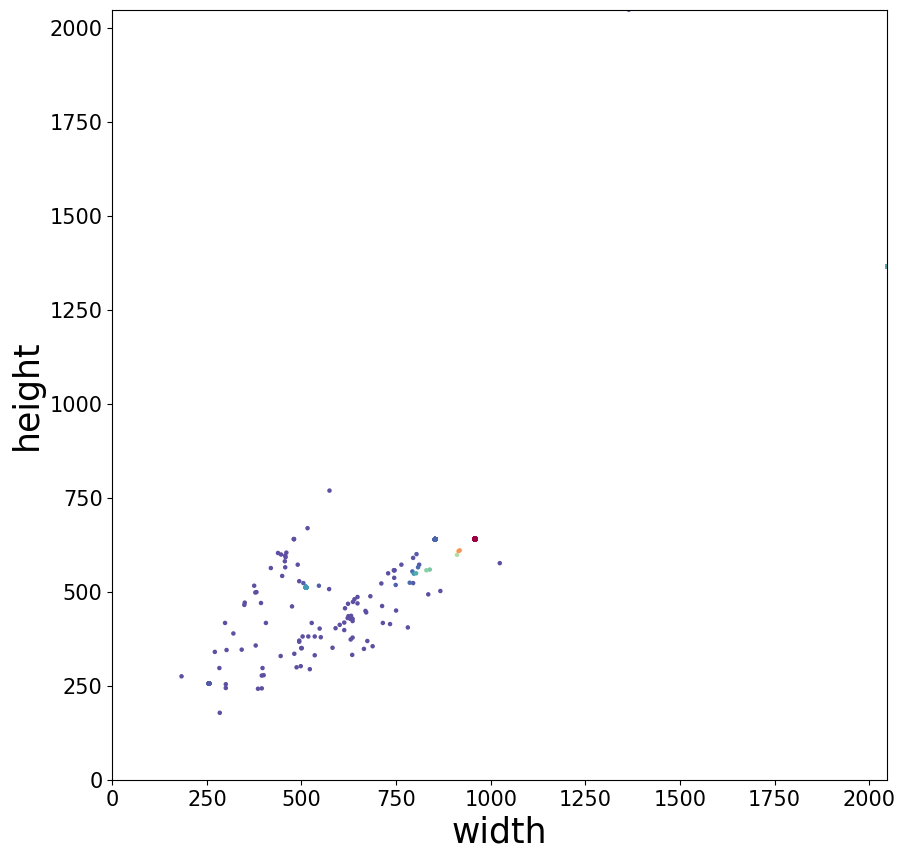

In [19]:
# 图片分布
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm

x = df['图像宽']
y = df['图像高']

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.figure(figsize=(10,10))
# plt.figure(figsize=(12,12))
plt.scatter(x, y, c=z,  s=5, cmap='Spectral_r')
# plt.colorbar()
# plt.xticks([])
# plt.yticks([])

plt.tick_params(labelsize=15)

xy_max = max(max(df['图像宽']), max(df['图像高']))
plt.xlim(xmin=0, xmax=xy_max)
plt.ylim(ymin=0, ymax=xy_max)

plt.ylabel('height', fontsize=25)
plt.xlabel('width', fontsize=25)

plt.savefig('图像尺寸分布.pdf', dpi=120, bbox_inches='tight')

plt.show()

# 划分训练集与验证集

In [21]:
import os
import shutil
import random
import pandas as pd

# 指定数据集路径
dataset_path = 'AppleLeaf9'
dataset_name = dataset_path.split('_')[0]
print('数据集', dataset_name)

数据集 AppleLeaf9


In [23]:
classes = os.listdir(dataset_path)
classes

['Mosaic',
 'Grey spot',
 'Alternaria leaf spot',
 'Frogeye leaf spot',
 'Powdery mildew',
 'Rust',
 'Health',
 'Brown spot',
 'Scab']

# 创建训练集和验证集文件夹

In [29]:
# 创建 train 文件夹
os.mkdir(os.path.join(dataset_path, 'train'))

# 创建 test 文件夹
os.mkdir(os.path.join(dataset_path, 'val'))

# 在 train 和 test 文件夹中创建各类别子文件夹
for i in classes:
    os.mkdir(os.path.join(dataset_path, 'train',i))
    os.mkdir(os.path.join(dataset_path, 'val',i))

# 划分训练集、测试集，移动文件

In [30]:
test_frac = 0.2  # 测试集比例
random.seed(123) # 随机数种子，便于复现
df = pd.DataFrame()

print('{:^18} {:^18} {:^18}'.format('类别', '训练集数据个数', '测试集数据个数'))

for fruit in classes: # 遍历每个类别

    # 读取该类别的所有图像文件名
    old_dir = os.path.join(dataset_path, fruit)
    images_filename = os.listdir(old_dir)
    random.shuffle(images_filename) # 随机打乱

    # 划分训练集和测试集
    testset_numer = int(len(images_filename) * test_frac) # 测试集图像个数
    testset_images = images_filename[:testset_numer]      # 获取拟移动至 test 目录的测试集图像文件名
    trainset_images = images_filename[testset_numer:]     # 获取拟移动至 train 目录的训练集图像文件名

    # 移动图像至 test 目录
    for image in testset_images:
        old_img_path = os.path.join(dataset_path, fruit, image)         # 获取原始文件路径
        new_test_path = os.path.join(dataset_path, 'val', fruit, image) # 获取 test 目录的新文件路径
        shutil.move(old_img_path, new_test_path) # 移动文件

    # 移动图像至 train 目录
    for image in trainset_images:
        old_img_path = os.path.join(dataset_path, fruit, image)           # 获取原始文件路径
        new_train_path = os.path.join(dataset_path, 'train', fruit, image) # 获取 train 目录的新文件路径
        shutil.move(old_img_path, new_train_path) # 移动文件
    
    # 删除旧文件夹
    assert len(os.listdir(old_dir)) == 0 # 确保旧文件夹中的所有图像都被移动走
    shutil.rmtree(old_dir) # 删除文件夹
    
    # 工整地输出每一类别的数据个数
    print('{:^18} {:^18} {:^18}'.format(fruit, len(trainset_images), len(testset_images)))
    
    # 保存到表格中
    df = df.append({'class':fruit, 'trainset':len(trainset_images), 'testset':len(testset_images)}, ignore_index=True)

# 重命名数据集文件夹
shutil.move(dataset_path, dataset_name+'_split')

# 数据集各类别数量统计表格，导出为 csv 文件
df['total'] = df['trainset'] + df['testset']
df.to_csv('数据量统计.csv', index=False)

        类别              训练集数据个数            测试集数据个数      
      Mosaic              297                 74        
    Grey spot             272                 67        
Alternaria leaf spot        334                 83        
Frogeye leaf spot         2545               636        
  Powdery mildew          948                236        
       Rust               2203               550        
      Health              413                103        
    Brown spot            329                 82        
       Scab               4328               1082       


# 查看文件目录结构

In [33]:
!tree /home/maoml/part_time_workspace/AppleLeaf9_split/ -L 2

/home/maoml/part_time_workspace/AppleLeaf9_split/
├── train
│   ├── Alternaria leaf spot
│   ├── Brown spot
│   ├── Frogeye leaf spot
│   ├── Grey spot
│   ├── Health
│   ├── Mosaic
│   ├── Powdery mildew
│   ├── Rust
│   └── Scab
└── val
    ├── Alternaria leaf spot
    ├── Brown spot
    ├── Frogeye leaf spot
    ├── Grey spot
    ├── Health
    ├── Mosaic
    ├── Powdery mildew
    ├── Rust
    └── Scab

20 directories, 0 files
